In [1]:
from __future__ import print_function
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics


## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)
print(newsgroups_train.target)
class_names = ['atheism', 'christian']

[1 0 1 ... 0 1 1]


In [3]:
newsgroups_test.data

['Could the guy who wrote the article "Why I am not Bertrand Russell"\nresend me a copy?',
 '[This was crossposted to a zillion groups.  I don\'t intend to\ncarry an entire discussion crossposted from alt.sex, particularly\none whose motivation seems to be having a fun argument.  However\nI thought readers might be interested to know about the\ndiscussion there.  --clh]\n\nI intend to endeavor to make the argument that homosexuality is an\nimmoral practice or lifestyle or whatever you call it.  I intend to\nshow that there is a basis for a rational declaration of this\nstatement.  I intend to also show that such a declaration can be \nmade without there being a religious justification for morality,\nin fact to show that such a standard can be made if one is an atheist.\n\nAnyone who wants to join in on the fun in taking the other side,\ni.e. that they can make the claim that homosexuality is not immoral,\nor that, collaterally, it is a morally valid practice, is free to do\nso.  I thin

Let's use the tfidf vectorizer, commonly used for text.

In [4]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)


Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [5]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
pred = rf.predict(test_vectors)
print(pred)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

[0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1
 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0
 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0
 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0
 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1
 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0
 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1
 1 0 1 1 1 1 0 0 0 1 0 1 

0.7651966626936829

We see that this classifier achieves a very high F score. [The sklearn guide to 20 newsgroups](http://scikit-learn.org/stable/datasets/#filtering-text-for-more-realistic-training) indicates that Multinomial Naive Bayes overfits this dataset by learning irrelevant stuff, such as headers. Let's see if random forests do the same.

## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implements predict_proba on raw_text lists.

In [7]:
from lime_text_new import LimeTextExplainer as LimeTextExplainer_new
from lime.lime_text import LimeTextExplainer as LimeTextExplainer_old

from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [8]:
print(c.predict_proba([newsgroups_test.data[0]]))

[[0.51188817 0.48811183]]


Now we create an explainer object. We pass the class_names as an argument for prettier display.

In [9]:
explainer_old = LimeTextExplainer_old(class_names=class_names)
explainer_new = LimeTextExplainer_new(class_names=class_names)


In [10]:
len(newsgroups_test.data)

717

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [94]:
#idx = np.random.randint(717)
idx = 290
print(newsgroups_test.data[idx])
#exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6,num_samples=1000)
exp_old_rf = explainer_old.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6,num_samples=600)
exp_new_rf = explainer_new.explain_instance(newsgroups_test.data,test_vectors,newsgroups_test.data[idx],idx, c.predict_proba,c, num_features=6,num_samples=600)

print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])


I certainly agree with the last paragraph.  Also, Jesus;s statements on
hell can be treated as totally symbolic, allegorical or as parables, as
was much of his other teaching.  There's more than enough hell here on earth
that we are freed from by following Jesus that the rest just doesn't mattter
to me.  And the fact that we can be free of the hell here is the best gift
God offers.  Eternal life begins for us now and we do not wait to start
partaking of the divine nature and journeying on the path to deification.

Larry Overacker (llo@shell.com)
-- 


C:\Users\Atin\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
C:\Users\Atin\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 290
Probability(christian) = 0.696
True class: christian


The classifier got this example right (it predicted atheism).  
The explanation is presented below as a list of weighted features. 

In [44]:
exp_old_rf.as_list()

[('Christian', 0.0935951534690679),
 ('Jesus', 0.07279953954071702),
 ('that', -0.042814914230395074),
 ('his', 0.03097313005091251),
 ('and', 0.027809878666108408),
 ('for', 0.026539150330358155)]

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. Roughly, if we remove 'Posting' and 'Host' from the document , the prediction should move towards the opposite class (Christianity) by about 0.27 (the sum of the weights for both features). Let's see if this is the case.

In [45]:
exp_new_rf.as_list()

[('the', 0.5927343794482365),
 ('to', 0.457846487768631),
 ('of', 0.42017450449941135),
 ('Jesus', 0.395157724901499),
 ('Christian', 0.3700347664313872),
 ('his', 0.3297899359695435)]

## Visualizing explanations

The explanations can be returned as a matplotlib barplot:

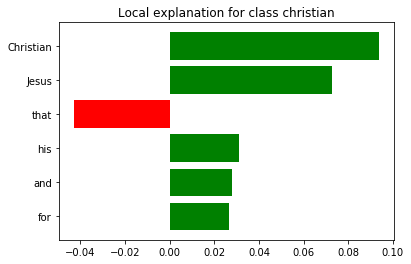

In [46]:
%matplotlib inline
fig = exp_old_rf.as_pyplot_figure()


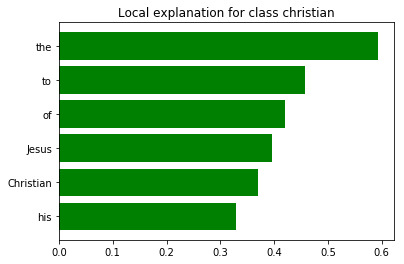

In [47]:
%matplotlib inline
fig = exp_new_rf.as_pyplot_figure()

The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs.  


In [48]:
exp_old_rf.show_in_notebook(text=True)

In [49]:
exp_new_rf.show_in_notebook(text=True)

Alternatively, we can save the fully contained html page to a file:

In [90]:
   
matching = [s for s in newsgroups_test.data if "I certainly agree with" in s ]
type(matching)

list

In [91]:
len(matching)

1

In [92]:
matching[0]

"\nI certainly agree with the last paragraph.  Also, Jesus;s statements on\nhell can be treated as totally symbolic, allegorical or as parables, as\nwas much of his other teaching.  There's more than enough hell here on earth\nthat we are freed from by following Jesus that the rest just doesn't mattter\nto me.  And the fact that we can be free of the hell here is the best gift\nGod offers.  Eternal life begins for us now and we do not wait to start\npartaking of the divine nature and journeying on the path to deification.\n\nLarry Overacker (llo@shell.com)\n-- "

In [93]:
newsgroups_test.data.index(matching[0])

290

In [ ]:
exp.save_to_file('/tmp/oi.html')

Finally, we can also include a visualization of the original document, with the words in the explanations highlighted. Notice how the words that affect the classifier the most are all in the email header.

In [ ]:
exp.show_in_notebook(text=True)

That's it for this tutorial. Random forests were just an example, this explainer works for any classifier you may want to use, as long as it implements predict_proba.